In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from dcgan.model import GanModel
from keras.datasets import mnist
import math
%matplotlib inline

def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = img
        
    return image

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = np.expand_dims(X_train, -1)

gan = GanModel()

Using TensorFlow backend.


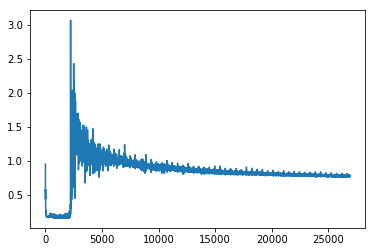

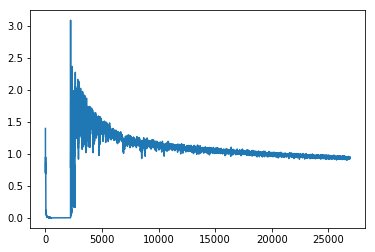

In [6]:
gan.train((X_train, y_train), (X_test, y_test), epochs=2000)
plt.plot(gan.d_loss)
plt.show()
plt.plot(gan.g_loss)
plt.show()

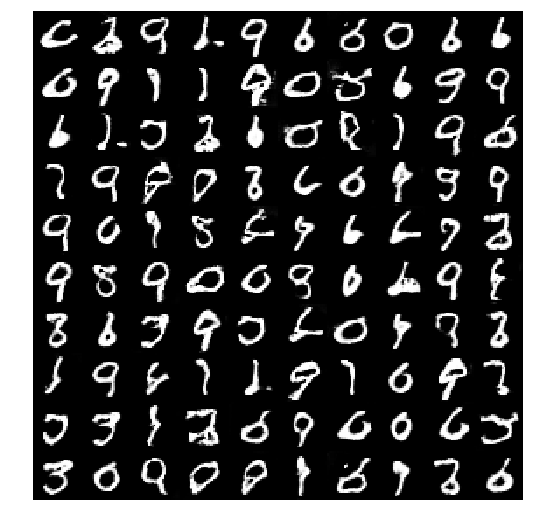

In [26]:
test = gan.generate(100, 0)
test = test.reshape([-1,28,28])
plt.figure(figsize=(9,9))
plt.imshow(combine_images(test), 'gray')
plt.axis('off')
plt.show()

In [25]:
!ls -lh

total 35M
-rw-rw-r--. 1 m20163692 m20163692 2.7M Apr 26 11:15 data.npy
drwxrwxr-x. 3 m20163692 m20163692 4.0K Apr 26 03:11 dcgan
-rw-rw-r--. 1 m20163692 m20163692 230K Apr 26 11:15 discriminator.h5
-rw-rw-r--. 1 m20163692 m20163692  32M Apr 26 11:15 generator.h5
-rw-rw-r--. 1 m20163692 m20163692   15 Apr 25 01:32 README.md
-rw-rw-r--. 1 m20163692 m20163692 6.6K Apr 25 01:32 temp.py
-rw-rw-r--. 1 m20163692 m20163692 111K Apr 26 11:19 tests.ipynb
